<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_4/M_MPlain_grande.png" height="300" width="300"> 

# <center> R для тервера и матстата. <br>  <br> 4.2 Максимальное правдоподобие, часть первая! </center>

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2017-2018). Автор ноутбука [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

---------


Метод максимального правдоподобия — это основная лошадка современной статистики. Функция правдоподобия встречается абсолютно во всех областях от эконометрики и байесовской статистики до нейронных сетей и рекомендательных систем. Из-за этого очень важно как следует понять как она устроена. 

В этой тетрадке именно этим мы и займёмся. Для начала мы попробуем посмотреть на поднаготную метода максимального правдоподобия и понять где это там в нём зарыта информация Фишера. И почему это вообще информация. Скорее всего, вас довольно давно будоражит этот вопрос. Затем мы решим в R парочку задачек. 

In [1]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

## 1. Пытаемся прочувствовать функцию правдоподобия на картинках

Пришло время формул! Итак, пусть в нашем распоряжении оказалась выборка $x_1, \ldots x_n$. Пусть мы предположили, что эту выбору на нас из сундука выплюнула случайная величина с плотностью распределения $f(x \mid \theta)$. Про параметр $\theta$ нам ничего не известно и мы хотели бы оценить его по выборке. 

Запишем правдоподобие наших данных, то есть вероятность пронаблюдать именно эту выборку: 

$$L( \theta \mid x_1, \ldots, x_n) = f(x_1, \ldots, x_n \mid \theta) = \prod_{i=1}^n f(x_i \mid \theta)$$

Наша выборка - фиксирована. При разных значениях $\theta$ мы получаем большую или меньшую вероятность получить выборку близку к наблюдаемой. Было бы круто найти такое значение $\theta$, для которого эта вероятность оказалась бы максимальной. 

Обратите внимание, что функцию $L( \theta \mid x_1, \ldots, x_n)$ уже нельзя трактовать как плотность распределения. Параметр $\theta$ здесь не рассматривается как случайная величина, он фиксирован. Интеграл $L( \theta \mid x_1, \ldots, x_n)$ по всем возможным значениям $\theta$ не будет равен единице. 

Для максимизации правдоподобия нам придётся брать производные. Куда приятнее их брать от логарифма, потому что все произведения превратятся в суммы и жить станет проще. Выпишем логарифм правдоподобия:

$$
\ln L( \theta \mid x_1, \ldots, x_n) =  \sum_{i=1}^n \ln f(x_i \mid \theta).
$$

Берём производную и приравниваем её к нулю. 

$$
\frac{\partial \ln L}{\partial \theta} = \sum_{i=1}^n \frac{\partial \ln f(x_i \mid \theta)}{\partial \theta} = 0
$$

Решив это уравнение мы получим оценку максимального правдоподобия. 


Посмотрим на одно слагаемое $\ln f(x_i \mid \theta)$. Его можно интерпретировать как логарифм правдоподобия, посчитанного на основании только одного наблюдения $x_i$.

Когда у нас в выборке появляются новые наблюдения, к нашей функции плюсуется дополнительное слагаемое. Интересно было бы посмотреть на то, как при этом функция изменяется. 

У нас есть R. Сгенерируем выборку объёма $5$ из нормального стандартного распределения и посмотрим. 

In [2]:
x <- rnorm(5)
x

[1]  0.9896431 -1.0702564  0.6559927  0.1351266  0.6491124

Выпишем для нормального распределения логарифмическую функцию правдоподобия. Она будет зависеть от двух векторов: выборки и параметров.

$$
\ln L(\mu, \sigma^2 \mid x) = -\frac{n}{2}\ln(2\pi)-\frac{n}{2}\ln(\sigma)-\sum_{i=1}^n\frac{(x_i - \mu)^2}{2\sigma^2}
$$


Предположим, что $\sigma$ известна и нам хочется оценить только $\mu$. Перебьём такую функцию в R.

In [3]:
# mu - оцениваемый параметр
# data - вектор данных

log_lik <- function(mu,data) {
  n <- length(data)
  result <- -n/2*log(2*pi)-n/2*log(1)-sum((data-mu)^2)/(2*1)
  return(result)
}

Найдём значение нашей функции в какой-нибудь точке чисто ради фана.

In [4]:
log_lik(1,x)
log_lik(10,x)

[1] -7.232462

[1] -242.4959

Посмотрим как функция выглядит на картинке.

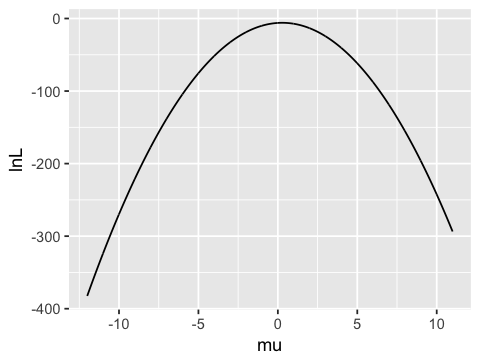

In [5]:
mu  = seq(-12,11,0.01)
lnL = rep(0,length(mu))

for(i in 1:length(lnL)){
    lnL[i] = log_lik(mu[i],x)
}

qplot(mu, lnL, geom='line')

Выглядит прелестно. Её максимум достигается в районе нуля, но не чётко в нуле. Построим такие же функции для отдельных наблюдений. 

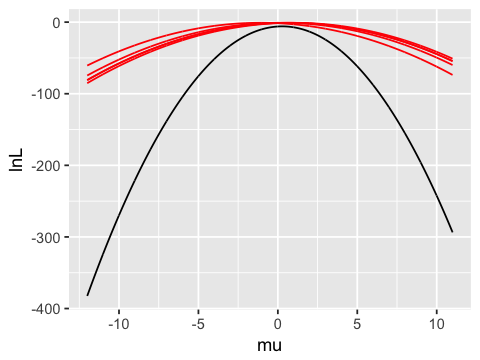

In [6]:
mu  = seq(-12,11,0.01)

lnL = rep(0,length(mu))
lnL1 = rep(0,length(mu))
lnL2 = rep(0,length(mu))
lnL3 = rep(0,length(mu))
lnL4 = rep(0,length(mu))
lnL5 = rep(0,length(mu))

for(i in 1:length(lnL)){
    lnL[i] = log_lik(mu[i],x)
    lnL1[i] = log_lik(mu[i],x[1])
    lnL2[i] = log_lik(mu[i],x[2])
    lnL3[i] = log_lik(mu[i],x[3])
    lnL4[i] = log_lik(mu[i],x[4])
    lnL5[i] = log_lik(mu[i],x[5])
}

df_L = data.frame(mu=mu,lnL = lnL, lnL1 = lnL1, lnL2 = lnL2,
                  lnL3 = lnL3,lnL4 = lnL4,lnL5 = lnL5)

ggplot(df_L, aes(x=mu))+
    geom_line(aes(y=lnL))+
    geom_line(aes(y=lnL1),color='red')+
    geom_line(aes(y=lnL2),color='red')+
    geom_line(aes(y=lnL3),color='red')+
    geom_line(aes(y=lnL4),color='red')+
    geom_line(aes(y=lnL5),color='red')

Черная функция для всей выборки равна сумме логарифмических правдоподобий для отдельных наблюдений (красные линии). Она имеет более выраженный максимум по сравнению с логарифмическими функциями для отдельных наблюдений. 

Можно построить аналогичную картинку, на которой мы будем постепенно накапливать наблюдения внутри нашей суммы. При добавлении всё новых слагаемых, максимум будет становиться более чётким. 

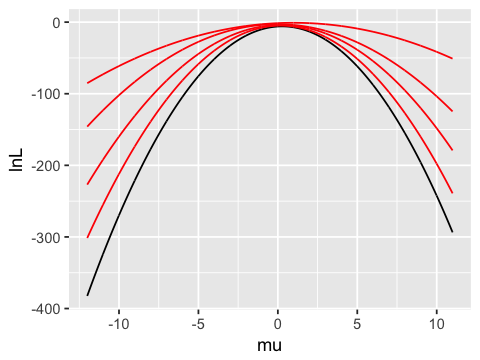

In [7]:
mu  = seq(-12,11,0.01)

lnL = rep(0,length(mu))
lnL1 = rep(0,length(mu))
lnL2 = rep(0,length(mu))
lnL3 = rep(0,length(mu))
lnL4 = rep(0,length(mu))
lnL5 = rep(0,length(mu))

for(i in 1:length(lnL)){
    lnL[i] = log_lik(mu[i],x)
    lnL1[i] = log_lik(mu[i],x[1])
    lnL2[i] = log_lik(mu[i],x[1:2])
    lnL3[i] = log_lik(mu[i],x[1:3])
    lnL4[i] = log_lik(mu[i],x[1:4])
}

df_L = data.frame(mu=mu,lnL = lnL, lnL1 = lnL1, lnL2 = lnL2,
                  lnL3 = lnL3,lnL4 = lnL4)

ggplot(df_L, aes(x=mu))+
    geom_line(aes(y=lnL))+
    geom_line(aes(y=lnL1),color='red')+
    geom_line(aes(y=lnL2),color='red')+
    geom_line(aes(y=lnL3),color='red')+
    geom_line(aes(y=lnL4),color='red')

Итак, чем более выпукла функция, тем более выражен максимум, тем более сильно мы уверенны в том, что оценка параметра была найдена хорошо.

Что отвечает за выпуклость функции? Правильно! Вторая производная. Именно её, взятую со знаком минус, интерпретируют как наблюдённую информацию.  

$$
I_o(\theta) =  - \left( \frac{\partial^2 \ln L}{\partial \theta^2}  \right)
$$

Почему со знаком минус? Потому что у нас максимум, в точке максимума вторая производная отрицательна. А информация должна быть положительной. Если параметр векторный, то в этом случае наблюдэнная информация представляется наблюдённой информационной матрицей: 

$$
I_o(\theta) =  - \left( \frac{\partial^2 \ln L}{\partial \theta_i \partial \theta_j}  \right) = - H
$$

Индекс o в данном случае обозначает observed, информацию, которую мы реально видели. В матрице на во всех клетках стоят числа. Они зависят от конкретных значений наблюдений. 

Обратите внимание, что на первой картинке, правдоподобия, построенные для разных наблюдений выпуклы по разному. Получается, что каждое наблюдение вносит в заострённость нашего правдоподобия разный вклад, то есть в каждом наблюдении содержится разное количество информации. 

Математическое ожидание этой матрицы по распределению $x$ называется информационной матрицей Фишера. 

$$
I(\theta) =  - E\left( \frac{\partial^2 \ln L}{\partial \theta_i \partial \theta_j}  \right) = -E(H)
$$

Ожидаемая информация зависит только от закона распределения наблюдений. Она отражает то, какую информацию в среднем вносит в наше правдоподобие, каждое наблюдение. 

Если функция плотности $f(x \mid \theta)$ удовлетворяет условиям регулярности, то тогда для любой несмещённой оценки $\hat \theta$ выполняется неравенство Рао-Фреше-Крамера: 

$$
Var(\hat \theta) \ge [I(\theta)]^{-1}
$$

Более того, в этом случае 

$$
I(\theta) =  - E\left( \frac{\partial^2 \ln L}{\partial \theta^2}  \right) = E\left[ \left( \frac{\partial \ln L}{\partial \theta} \right)^2  \right],
$$

но доказывать это здесь, мы конечно же не будем. 

При тех же условиях регулярности, оценка максимального правдоподоия обладает набором приятных асимптотических свойств: 

1. Состоятельность 
2. Асимптотическая несмещённость
3. Асимптотическая эффективность
4. Асимптотическая нормальность: 

$$
\hat \theta \to N(\theta, I(\theta)^{-1}) 
$$


Асимптотическую нормальность обычно используют на практике для строительства доверительных интервалов и проверки гипотез. Чтобы сделать это, yужно найти подходящую оценку для информации Фишера, посчитанную на основе выборки. 

Обычно поступают двумя путями: либо заменяют в матрице Гессе, $-H$, все $\theta$ на оценки, либо заменяют в матрице $-E(H)$ все $\theta$ на оценки. Именно так мы с вами поступим, когда будем решать задачки.

## 2. Задача об эм-энд-эмсинах

Я купил несколько упаковок с конфетками и посчитал как часто в них встречаются жёлтые конфетки и красные конфетки. Красных оказалось $46$ штук. Жёлтых $44$ штуки. Остальных цветов $237$ штук. Распределение конфеток на мой взгляд выглядит следующим образом: 

| X | красная | жёлтая | другой цвет   |
|---|---------|--------|---------------|
|   |  $p_1$  |  $p_2$ |  $1-p_1 - p_2$|

У нас в выборке есть $x_1$ красных конфеток и $x_2$ жёлтых. $p_1$ и $p_2$ это ненаблюдаемые константы. $X_1$ и $X_2$ это наблюдаемые случайные величины. Наша цель найти $\hat p_1(X_1, X_2)$ и  $\hat p_2(X_1, X_2)$. 

Для этого выписываем функцию правдоподобия! 

$$
L = p_1^{X_1} \cdot p_2^{X_2} \cdot (1-p_1-p_2)^{n-X_1-X_2}
$$

Логарифмируем её:

$$
ln L = X_1 \ln p_1 + X_2 \ln p_2 + (n - X_1 - X_2) \ln(1-p_1-p_2)
$$

Чтобы найти максимум, берём производные!

$$
\begin{cases} 
\frac{\partial \ln L}{\partial p_1} = \frac{X_1}{p_1} - \frac{n-X_1-X_2}{1-p_1-p_2} \\
\frac{\partial \ln L}{\partial p_2} = \frac{X_2}{p_2} - \frac{n-X_1-X_2}{1-p_1-p_2}
\end{cases}
$$

Приравниваем всё это добро к нулю, на буквами $p$ появляются колпачки. С этого момента мы имеем дело с оценками параметров. При настоящих значениях $p$ производные могут быть не равны нулю в доставшихся нам $x_i$. 

В результате решения системы получаем, что 

$$
\begin{cases} 
\hat p_1^{ML} = \frac{X_1}{n} \\
\hat p_2^{ML} = \frac{X_2}{n}
\end{cases}
$$

В общем то это довольно логичный результат. То, что я вижу вне ящика, то и происходит в ящике. Таковы наши оценки. 

Займёмся вторыми производными. Через них найдём оценку информационной матрицы $I$. Это можно сделать двумя способами: найти $-H$ и подставить в неё $\hat p$, либо найти $-E(H)$  и подставить в неё $\hat p$. Дальше мы можем найти оценку для $Var(\hat p)$. Эта оценка позволит нам построить для оценок $\hat p$ доверительные интервалы и понять насколько точными получились наши оценки. 

Найдём матрицу Гессе:

$$
H = \begin{pmatrix} 
\frac{\partial^2 \ln L}{\partial p_1^2}, \frac{\partial^2 \ln L}{\partial p_1 \partial  p_2} \\
\frac{\partial^2 \ln L}{\partial p_2 \partial p_1}, \frac{\partial^2 \ln L}{\partial p_2^2}
\end{pmatrix}
$$

Сделать это несложно. Нужно просто взять четыре производные. 

$$
H = \begin{pmatrix} 
-\frac{X_1}{p_1^2} - \frac{n-X_1 -X_2}{(1-p_1-p_2)^2}, - \frac{n-X_1 -X_2}{(1-p_1-p_2)^2} \\
- \frac{n-X_1 -X_2}{(1-p_1-p_2)^2}, -\frac{X_2}{p_2^2} - \frac{n-X_1 -X_2}{(1-p_1-p_2)^2}
\end{pmatrix}
$$

$-H$ в точке $\hat p$ будет оценкой информационной матрицы. Осталось подставить в неё $\hat p$ и обратить. Делать это вручную лениво. Давайте воспользуемся для этого мощью R.

In [10]:
# задаем оценку информационной матрицы руками
# Первый способ - подставим в -H оценки параметров: 
x1 = 46
x2 = 44 
x3 = 237 
n = x1 + x2 + x3

hat.I <- matrix(c(x1/0.14^2+237/0.73^2, 237/0.73^2,
                  237/0.73^2, x2/0.14^2+237/0.73^2),nrow=2)
hat.I

2791.6751,444.7363
444.7363,2689.6343


In [11]:
# считаем обратную --- это будет оценка ковариационной матрицы ошибок
hat.Var <- solve(hat.I)
hat.Var

3.678990e-04,-6.083283e-05
-6.083283e-05,3.818566e-04


Мы получили оценку ковариационной матрицы для наших параметров $\hat p_1$ и $\hat p_2$. На диагонали стоят оценки дисперсий этих параметров, на побочной диагонали стоит ковариация между нашими оценками. 

Построи оценку ковариационной матрицы вторым способом. Для этого найдём $E(H)$. Как мы помним, $X_i \sim Bin(n,p_1)$. Значит $E(X_1) = np_1$. Получается, что: 

$$
E(H) = \begin{pmatrix} 
-\frac{n}{p_1} - \frac{n}{1-p_1-p_2}, - \frac{n}{1-p_1-p_2} \\
- \frac{n}{1-p_1-p_2}, -\frac{n}{p_2^2} - \frac{n}{1-p_1-p_2}
\end{pmatrix}
$$

Подставими в матрицу $\hat p$ и обратим её.

In [12]:
# Второй способ - подставим в -E(H) оценки параметров: 
hat.I <- matrix(c(n/0.14 + n/0.73, n/0.73,
                  n/0.73, n/0.14 + n/0.73),nrow=2)
hat.I

2783.6595,447.9452
447.9452,2783.6595


In [13]:
# считаем обратную --- это будет оценка ковариационной матрицы ошибок
hat.Var <- solve(hat.I)
hat.Var

3.687892e-04,-5.934538e-05
-5.934538e-05,3.687892e-04


Это милый результат, но он довольно ручной. Мне бы хотелось теперь проделать все те же изыскания в R от начала до конца. Однако сначала напомню про функции! Обычно, функции в R пишут тогда, когда нужно постоянно выполнять один и тот же кусок кода. Устроена функция как-то так:

In [14]:
# функция лена возводит числа в квадрат
lena <- function(x) {
  return(x^2)
}

lena(7)

[1] 49

В виде точно такой же функции можно записать нашу логарифмическую функцию правдоподобия. 

Она будет зависеть от двух аргументов: выборки и параметров, которые нужно оценить. В дальнейшем нам нужно максимизировать функцию правдоподобия. R умеет минимизировать. Поэтому домножим функцию на $-1$. Минимизируя $-L$, мы максимизируем $L$.

In [15]:
lnL <- function(p,X,n) {
    ans <- X[1]*log(p[1])+X[2]*log(p[2])+ (n-X[1]-X[2])*log(1-p[1]-p[2])
  return(-ans)
}

Убедимся, что сы сделали всё правильно и возьмём пробу в паре рандомных точек.

In [16]:
lnL(c(0.2,0.5),c(16,18),40)
lnL(c(0.2,0.3),c(16,18),40)

[1] 45.45149

[1] 51.5814

Дело за малым! Минимизировать :) 

In [39]:
?nlm  # можно почитать подсказку

In [18]:
# минимизируем минус правдоподобие <=> максимизируем правдоподобие
res <- nlm(lnL,c(1/3,1/3),
            hessian=TRUE,
            X=c(x1,x2),n)

Warning message in log(p[1]):
“созданы NaN”Warning message in log(p[2]):
“созданы NaN”Warning message in nlm(lnL, c(1/3, 1/3), hessian = TRUE, X = c(x1, x2), n):
“NA/Inf заменены максимальным положительным значением”Warning message in log(p[1]):
“созданы NaN”Warning message in log(p[2]):
“созданы NaN”Warning message in nlm(lnL, c(1/3, 1/3), hessian = TRUE, X = c(x1, x2), n):
“NA/Inf заменены максимальным положительным значением”Warning message in log(p[1]):
“созданы NaN”Warning message in log(p[2]):
“созданы NaN”Warning message in nlm(lnL, c(1/3, 1/3), hessian = TRUE, X = c(x1, x2), n):
“NA/Inf заменены максимальным положительным значением”Warning message in log(p[1]):
“созданы NaN”Warning message in log(p[2]):
“созданы NaN”Warning message in nlm(lnL, c(1/3, 1/3), hessian = TRUE, X = c(x1, x2), n):
“NA/Inf заменены максимальным положительным значением”

In [19]:
res

2772.5579,451.3006
451.3006,2877.9139


In [20]:
res$estimate # оценки правдоподобия

[1] 0.1406723 0.1345561

In [21]:
solve(res$hessian) # оценка ковариационной матрицы оценок

3.701254e-04,-5.804129e-05
-5.804129e-05,3.565757e-04


Матрицы совпали. Ура! Давайте попробуем теперь сделать то же самое, но при участии пакета, который занимается максимазицей правдоподобия самостоятельно. 

In [25]:
# install.packages('maxLik')  # если пакет не установлен
library('maxLik') # пакет для метода макс. правдоподобия

# Логарифмическое правдоподобие со знаком плюс!
# Грубо говоря, пакет сам домножает на минус единицу.

lnL <- function(p,X) {
    ans <- X[1]*log(p[1])+X[2]*log(p[2])+ (X[3])*log(1-p[1]-p[2])
  return(ans)
}

res <- maxLik(lnL, start=c(0.1,0.1),X=c(44,46,237))

summary(res) # краткий отчет о результатах оценивания

# первый столбик --- сами оценки по методу максимального правдоподобия
# второй столбик --- оценки стандартных ошибок
# т.е. корни из диагональных элементов оценённой ковариационной матрицы
# в третьем и четвёртом столбиках проверятся гипотеза о равенстве этих параметров нулю,
# но об этом позже :)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 4 iterations
Return code 1: gradient close to zero
Log-Likelihood: -254.7649 
2  free parameters
Estimates:
     Estimate Std. error t value  Pr(> t)    
[1,]  0.13456    0.01887   7.130 1.00e-12 ***
[2,]  0.14067    0.01923   7.316 2.55e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [26]:
res$estimate        # оценки
res$hessian         # оценка матрицы Гессе
solve(res$hessian)  # оценка ковариационной матрицы оценок

[1] 0.1345566 0.1406728

-2881.3361,-451.1946
-451.1946,-2775.7210


-3.561261e-04,5.788845e-05
5.788845e-05,-3.696765e-04


На картинке ниже находится эм-энд-мсовый тймлайн. Можно посмотреть в какие годы какими были цвета у конфеток.

<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_4/manams_col.png" height="750" width="750"> 


## 3. Угольные шахты и аварии на них

В [табличке](https://yadi.sk/i/wIFZJJ3X3VdPow) лежат данные о количестве крупных аварий на английских угольных шахтах.

In [27]:
df = read.csv('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/coal.csv', sep=',')
head(df)

X,year,count
1,1851,4
2,1852,5
3,1853,4
4,1854,1
5,1855,0
6,1856,4


[1] 112

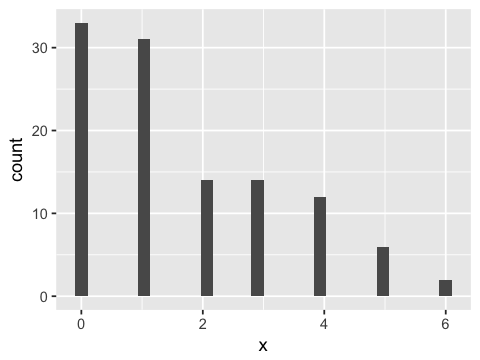

In [28]:
x <- df$count        # наша выборка 
length(x)            # размер выборки 
qplot(x, bins=30)

Судя по гистограмме уместно предположить, что число аварий имеет распределение Пуассона, $Poiss(\lambda)$. Попробуем оценить параметр $\lambda$ методом максимального правдоподобия. 

Вероятность значения: $$\frac{e^{-\lambda} \lambda^k}{k!}$$

Логарифмическое правдоподобие: $$ \sum x_i \ln \lambda - n \lambda$$

Производная номер один: $$ \frac{\partial \ln L}{\partial \lambda} =  \frac{\sum x_i}{\lambda}  - n $$

Оценка максимального правдоподобия: $$\hat \lambda^{ML} = \bar x$$

А теперь всё то эе самое, но в R!

In [29]:
lnL <- function(lambda, x) {
  n <- length(x)
  answer <- -lambda*n+log(lambda)*sum(x)
  return(answer)
}

In [30]:
# Пара значений функции
lnL(1, x)
lnL(0.5, x)

[1] -112

[1] -188.3911

In [31]:
result <- maxLik(lnL, start=2, x=x)
summary(result)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 4 iterations
Return code 1: gradient close to zero
Log-Likelihood: -89.04906 
1  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)    
[1,]   1.7054     0.1234   13.82  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [32]:
# сверимся с теорией! Оценка получилась хорошей :) 
mean(x)

[1] 1.705357

In [33]:
# Вытащим оценку в отдельную переменную
lambda_hat <- result$estimate
lambda_hat

[1] 1.705357

Вторая производная : $$ \frac{\partial^2 \ln L}{\partial \lambda^2} =  -\frac{\sum x_i}{\lambda^2} $$

В этой задачке только один параметр. Поэтому матрица гессе это только одна единственная производная. Давайте найдём оценку дисперсии для нашей $\hat \lambda$: 

$$
- H = \frac{\sum x_i}{\lambda^2}
$$

$$
- E(H) =  \frac{n}{\lambda}
$$

In [34]:
# Первая оценка: 
1/(sum(x)/lambda_hat^2)

[1] 0.0152264

In [35]:
# Вторая оценка: 
1/(length(x)/lambda_hat)

[1] 0.0152264

In [36]:
# Оценка из пакета: 
-1*1/result$hessian

0.01523463


Давайте попробуем воспользоваться этой оценкой. Мы с вами помним, что оценка максимального правдоподобия довольно няшная. Она имеет асимптотически нормальное распределение: 

$$\hat \lambda \sim N(\lambda, 0.01524)$$

Давайте построим для неё, отталкиваясь от этой информации доверительный интервал.

In [37]:
se = sqrt(-1*1/result$hessian)
lambda_left  = lambda_hat - qnorm(1-0.05/2)*se
lambda_right = lambda_hat + qnorm(1-0.05/2)*se
cat('Параметр lambda с вероятностью 95% лежит между',lambda_left, 'и',lambda_right)

Параметр lambda с вероятностью 95% лежит между 1.463441 и 1.947273

Обратите внимание, что интервал получился довольно коротким. Это сигнализирует о высокой точности оценки. Давайте посмотрим с какой вероятностью в следующем году произойдёт какое количество катастроф, то есть построим прогноз для наших угольных шахт:

In [38]:
f <- 0:5
round(exp(-lambda_hat)*lambda_hat^f/factorial(f),2)

[1] 0.18 0.31 0.26 0.15 0.06 0.02

Вероятнее всего на шахте произойдёт две катастрофы. Надо быть готовым к этому. На практике распределение Пуассона часто используют во всемирной организации здравоохрания. У каждого вируса гриппа есть свои особенности и нельзя привить людей сразу от всех недугов. Поэтому с помощью распределения Пуассона пытаются прогнозировать какие разновидности гриппа будут самыми популярными. Вакцину для прививок специфицируют именно под эти разновидности. Ясное дело, что они оценивают на основе распределения Пуассона более сложные модели. Какие именно, мы увидим на следующей паре.

Остался последний нюанс. Выше мы сказали, что если функция плотности $f(x \mid \theta)$ удовлетворяет условиям регулярности, то тогда для любой несмещённой оценки $\hat \theta$ выполняется:

$$
I(\theta) =  E\left( \frac{\partial^2 \ln L}{\partial \theta^2}  \right) = E\left[ \left( \frac{\partial \ln L}{\partial \theta} \right)^2  \right],
$$

то есть вторая производная является ничем иным как информацией Фишера. Давайте убедимся в этом на примере распределения Пуассона. Для простоты будем считать, что у нас есть только одно наблюдение и $\ln L = \ln f(x,\lambda)$. Если мы откроем семинары/лекции или ручками найдём информацию Фишера для распределения Пуассона, мы увидим, что:

$$
J(\lambda) = \frac{1}{\lambda}
$$

Это совпадает с $-E(H)$ для одного наблдюдения. __Остановитесь! И задумайтесь о том в чём смысл информации Фишера, при чём тут вторая производная и почему это информация.__ Если вы смогли ответить на эти вопросы, двигайтесь дальше. Если не смогли, то перечитайте начало блокнота. Если вы всё ещё ничего не поняли, пишите в лс :)